In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
co2_dataset = pd.read_csv('CO2_emission.csv')

In [4]:
co2_dataset.head(1)

,Country Name,country_code,Region,Indicator Name,1990,1991,1992,1993,1994,1995,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2019.1
0,Aruba,ABW,Latin America & Caribbean,CO2 emissions (metric tons per capita),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
co2_dataset.dropna(axis=0, inplace=True)
co2_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 214
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    183 non-null    object 
 1   country_code    183 non-null    object 
 2   Region          183 non-null    object 
 3   Indicator Name  183 non-null    object 
 4   1990            183 non-null    float64
 5   1991            183 non-null    float64
 6   1992            183 non-null    float64
 7   1993            183 non-null    float64
 8   1994            183 non-null    float64
 9   1995            183 non-null    float64
 10  1996            183 non-null    float64
 11  1997            183 non-null    float64
 12  1998            183 non-null    float64
 13  1999            183 non-null    float64
 14  2000            183 non-null    float64
 15  2001            183 non-null    float64
 16  2002            183 non-null    float64
 17  2003            183 non-null    flo

In [6]:
co2_dataset['Region'].unique()

array(['South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia',
       'Middle East & North Africa', 'Latin America & Caribbean',
       'East Asia & Pacific', 'North America'], dtype=object)

In [7]:
g = co2_dataset.groupby(by='Region').sum()

In [8]:
g.index

Index(['East Asia & Pacific', 'Europe & Central Asia',
       'Latin America & Caribbean', 'Middle East & North Africa',
       'North America', 'South Asia', 'Sub-Saharan Africa'],
      dtype='object', name='Region')

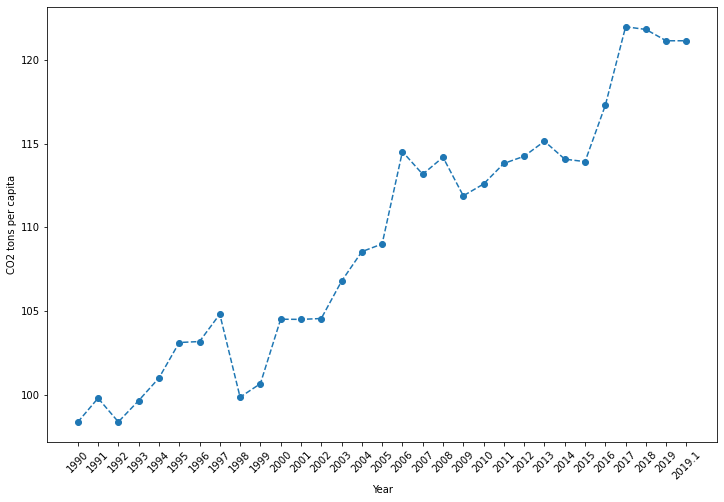

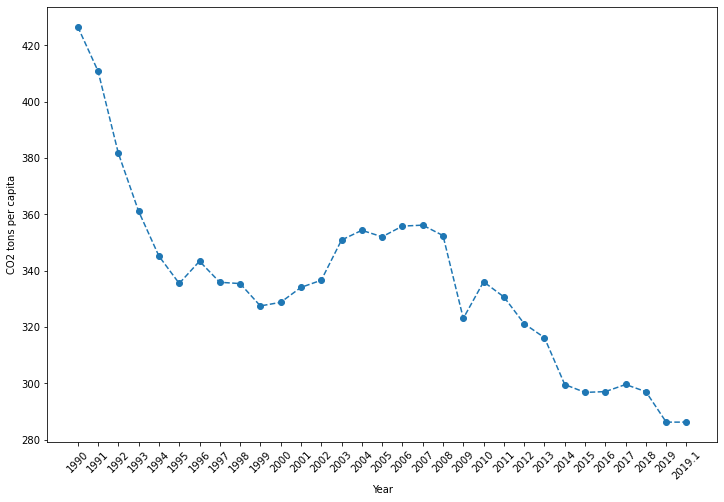

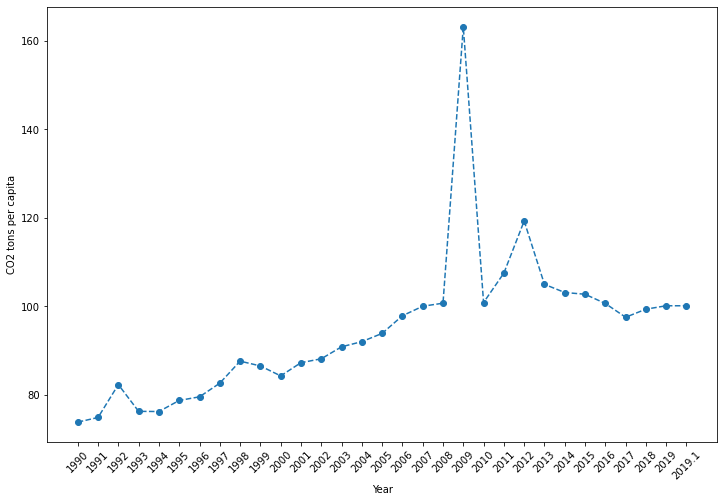

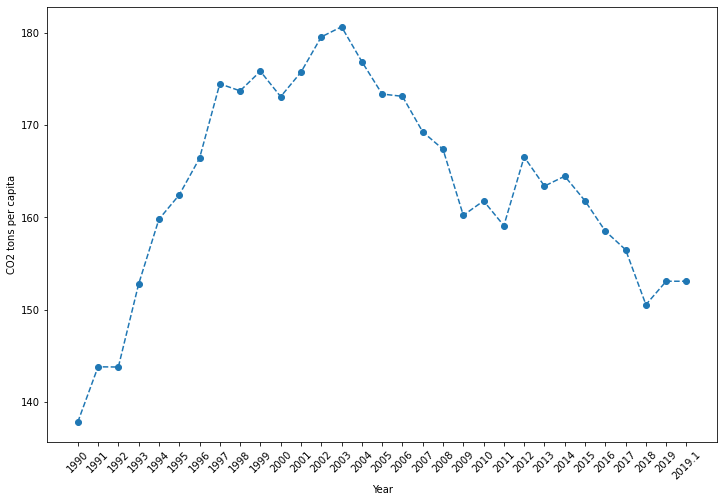

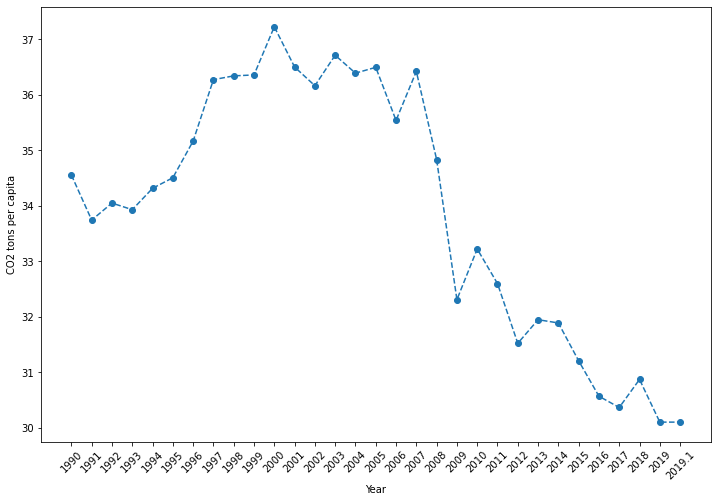

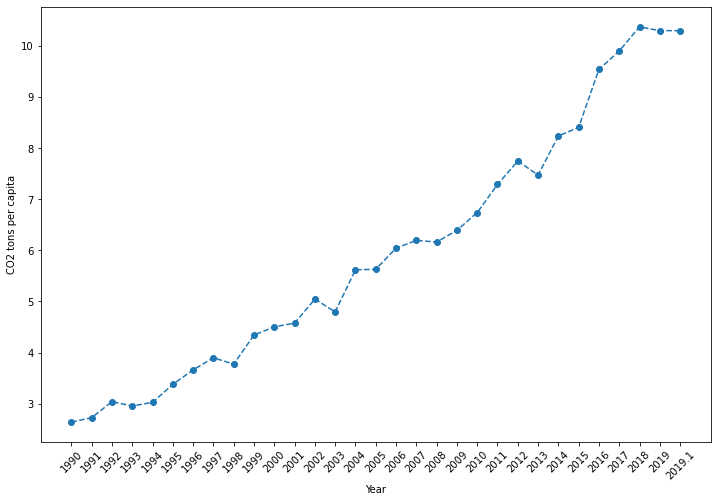

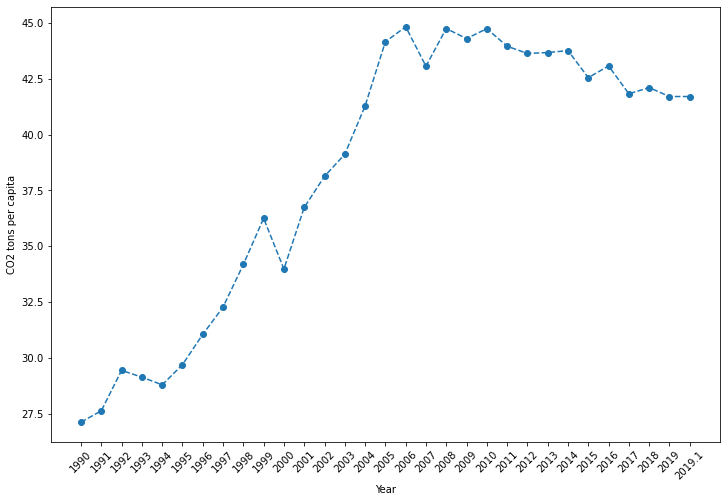

In [19]:
def plot_trends(data, feat):
    plt.figure(figsize=(12,8))
    plt.plot(data.loc[feat], '--o')
    plt.xlabel('Year')
    plt.ylabel('CO2 tons per capita')
    plt.xticks(rotation=45) 

[plot_trends(co2_dataset.groupby(by='Region').sum(), i) for i in g.index];
plt.show()

In [30]:
new_dataset = co2_dataset.groupby(by='Region').sum()
legends = new_dataset.index

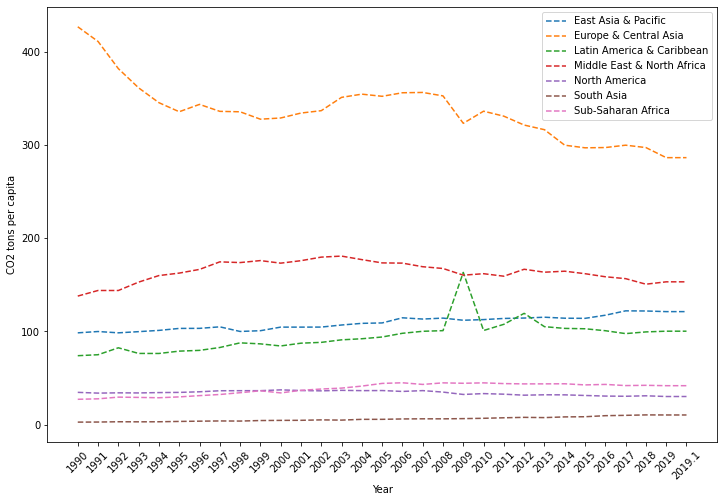

In [32]:
plt.figure(figsize=(12,8))
plt.plot(new_dataset.T, '--', label=legends)
plt.xlabel('Year')
plt.ylabel('CO2 tons per capita')
plt.xticks(rotation=45) 
plt.legend()
plt.show()


In [34]:
new_dataset.reset_index(inplace=True)
df = new_dataset.rename(columns = {'index':'Region'})

In [35]:
new_dataset

,Region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2019.1
0,East Asia & Pacific,98.373009,99.802271,98.386979,99.655951,101.003446,103.124329,103.182183,104.815299,99.862843,...,113.811910,114.239996,115.135462,114.067628,113.918365,117.279083,121.966613,121.807264,121.131826,121.131826
1,Europe & Central Asia,426.580142,410.837272,381.689259,361.074328,345.182576,335.477591,343.361999,335.886209,335.422792,...,330.701016,321.189953,316.231169,299.593460,296.797127,297.071287,299.601600,297.051216,286.244383,286.244383
2,Latin America & Caribbean,73.863953,74.914989,82.343662,76.298756,76.258303,78.760998,79.581012,82.659459,87.639062,...,107.527254,119.294947,104.991859,103.144721,102.749714,100.662825,97.555050,99.377463,100.148730,100.148730
3,Middle East & North Africa,137.802569,143.802469,143.778778,152.773977,159.803849,162.442157,166.411935,174.492070,173.730181,...,159.110188,166.565667,163.399399,164.477529,161.797789,158.516955,156.496772,150.538558,153.082133,153.082133
4,North America,34.556236,33.744417,34.051095,33.931719,34.316557,34.507511,35.167971,36.274841,36.342812,...,32.600162,31.524257,31.949645,31.890826,31.208621,30.570487,30.367832,30.873127,30.104023,30.104023
5,South Asia,2.636176,2.723893,3.037818,2.952127,3.023854,3.375510,3.661086,3.896621,3.772312,...,7.292716,7.749087,7.477978,8.241143,8.411531,9.547236,9.907264,10.381212,10.304685,10.304685
6,Sub-Saharan Africa,27.117814,27.625659,29.435103,29.132057,28.787870,29.691015,31.046645,32.271409,34.178591,...,43.955300,43.631622,43.671660,43.759554,42.547119,43.073010,41.824696,42.100814,41.702448,41.702448


In [37]:
new_dataset.to_csv('co2_emissions_region.csv', index=False)